## Sedaro Validation Notebook
### Attitude Dynamics

Compare the results of a Sedaro simulation with closed-loop attitude control to a Basilisk simulation with the same commanded reaction wheel torques. Basilisk is a software framework for 
astrodynamics simulations developed by the Autonomous Vehicle Systems Lab and Laboratory for Atmospheric and Space
Physics at CU Boulder. More information about Basilisk can be found here: https://hanspeterschaub.info/basilisk/

Since the Basilisk simulation features open-loop control, we can isolate the attitude dynamics and kinematics for validation. We expect the attitude in Basilisk to diverge eventually since there is no feedback loop to suppress any perturbations. This is analogous to commanding the physical twin of the Sedaro model without feedback, and the result will in turn characterize a time-scale for which the digital twin can reproduce the exact attitude behavior of the physical one.

### Reproducing our Results

To ensure reproducibility, the directory containing this notebook also includes a `requirements.txt` file that specifies the exact package versions that were used. To create a similar environment, use the following sequence of commands with Python `3.11` and the built-in `venv` package. See the [venv documentation](https://docs.python.org/3/library/venv.html) for more details on how this works.

- In a unix-like terminal:

    ```zsh
    > python -m venv .venv
    > source .venv/bin/activate
    > pip install -r requirements.txt
    ```

- In a Windows `cmd.exe` terminal:
    ```bat
    C:\> python -m venv .venv
    C:\> .venv\Scripts\activate.bat
    C:\> pip install -r requirements.txt
    ```

- In Windows PowerShell:

    ```bat
    C:\> python -m venv .venv
    C:\> .venv\Scripts\Activate.ps1
    C:\> pip install -r requirements.txt
    ```

Confirm that the Jupyter notebook is using this virtual environment before running the code below.

In [ ]:
import json
import os
import matplotlib.pyplot as plt
import numpy as np
from utils import mrp_to_quaternion, angleBetweenClosestQuaternions, sedaroLogin, download_file

### Important: Read Before Running

This notebook requires that you have previously generated an API key in the web UI. That key should be stored in a file called `secrets.json` in the root directory of this repository (two levels above this notebook) with the following format:

```json
{
    "API_KEY": "<API_KEY>"
}
```

API keys grant full access to your repositories and should never be shared. If you think your API key has been
compromised, you can revoke it in the user settings interface on the Sedaro website.

This notebook also requires specific configuration of the HOST and branch ids by defining them below or by
including the following in `config.json`. You should use the default `config.json` ids unless you are re-running the scenario.

```jsonc
{
  "HOST": "<HOST>",
  "VALIDATION": {
    "VALIDATION_ATTITUDE": {
      "ACTIVE_SCENARIO_BRANCH_ID": "<BRANCH ID>",
      // etc.
      }
  }
}

## Download Scenario and Basilisk Simulation Data
This notebook considers the following reference scenario(s):
- [main](https://satellite.sedaro.com/#/scenario/PLMgnkkP6VfSWwnQxjKntp/analyze/playback?job=PLMgttkvM8VBp23yqmky6y&start=60322.8125&stop=60322.88055555556&res=8&share=5654b41a-1e0c-4aa3-9327-73fbde91c4e3)
- [passive](https://satellite.sedaro.com/#/scenario/PLMgrcrZzLgRdYgrMvpblq/analyze/playback?job=PLMhP84jtT4xlmrxXPf2zy&start=60322.8125&stop=60322.88055555556&res=8&share=93d58b73-cec8-416e-af6b-7ba5dcc08282)

In [3]:
sedaro = sedaroLogin()
with open('../../config.json', 'r') as file:
    nb_config = json.load(file)['VALIDATION']['ATTITUDE']
ACTIVE_SCENARIO_BRANCH_ID = nb_config['ACTIVE_SCENARIO_BRANCH_ID']
PASSIVE_SCENARIO_BRANCH_ID = nb_config['PASSIVE_SCENARIO_BRANCH_ID']
AGENT_TEMPLATE_BRANCH_ID = nb_config['AGENT_TEMPLATE_BRANCH_ID']

# Scenario selection
scenario = 'active'
match scenario:
    case 'active':
        scenario_branch_id = ACTIVE_SCENARIO_BRANCH_ID
        results_file = 'basilisk_results_active.json'
    case 'passive':
        scenario_branch_id = PASSIVE_SCENARIO_BRANCH_ID
        results_file = 'basilisk_results_passive.json'

# Download results
results = sedaro.scenario(scenario_branch_id).simulation.results()

per_agent_results = {}
for agent_name in results.templated_agents:
    per_agent_results[agent_name] = results.agent(agent_name)

Downloading...
...download complete!


In [4]:
basilisk_results_url = 'https://sedaro-modsim-artifacts.s3.us-gov-east-1.amazonaws.com/'
if not os.path.exists(f'reference_data/{results_file}'):
    download_file(basilisk_results_url+results_file, f'reference_data/{results_file}')

with open(f'reference_data/{results_file}', 'r') as f:
    basilisk_results = json.load(f)

Get static wheel ids from the Agent Template

In [5]:
vehicle = sedaro.agent_template(AGENT_TEMPLATE_BRANCH_ID)
wheels = vehicle.ReactionWheel.get_all()
x_wheel_id = next(wheel.id for wheel in wheels if 'X' in wheel.name)
y_wheel_id = next(wheel.id for wheel in wheels if 'Y' in wheel.name)
z_wheel_id = next(wheel.id for wheel in wheels if 'Z' in wheel.name)

## Prepare Data

Get dictionaries of the quantities of interest from the Sedaro simulation keyed by the name of each agent.

In [6]:
sedaro_attitude_results = {name: np.array(r.block('root').attitude.body_eci.values) for name, r in per_agent_results.items()}
sedaro_omega_x = {name: np.array(r.block(x_wheel_id).speed.values) for name, r in per_agent_results.items()}
sedaro_omega_y = {name: np.array(r.block(y_wheel_id).speed.values) for name, r in per_agent_results.items()}
sedaro_omega_z = {name: np.array(r.block(z_wheel_id).speed.values) for name, r in per_agent_results.items()}
sedaro_gg = {name: np.array(r.block('root').gravityGradientTorque.values) for name, r in per_agent_results.items()}
sedaro_ts = {name: r.block('root').attitude.body_eci.elapsed_time for name, r in per_agent_results.items()}

Format basilisk results

In [7]:
basilisk_agent_attitude = {name: [
    mrp_to_quaternion(mrp) for mrp in r['attitude_mrp']
    ] for name, r in basilisk_results.items()}
basilisk_gg = {name: np.array(r['gg_torque']) for name, r in basilisk_results.items()}
basilisk_agent_time_arr = {name: np.array(r['time']) for name, r in basilisk_results.items()}
basilisk_omega_x = {name: np.array(r['rw_x_omega']) for name, r in basilisk_results.items()}
basilisk_omega_y = {name: np.array(r['rw_y_omega']) for name, r in basilisk_results.items()}
basilisk_omega_z = {name: np.array(r['rw_z_omega']) for name, r in basilisk_results.items()}

## Visualize Results


In [8]:
sedaro_savoy = '#4f64ce'
basilisk_gold = '#CFB87C'

### Attitude Quaternions
Generate plots of the attitude quaternions produced by Sedaro and Basilisk for each agent. Note that q and -q correspond to the same rotation, so I've plotted both for the Sedaro data, since the representation from Basilisk sometimes flips.

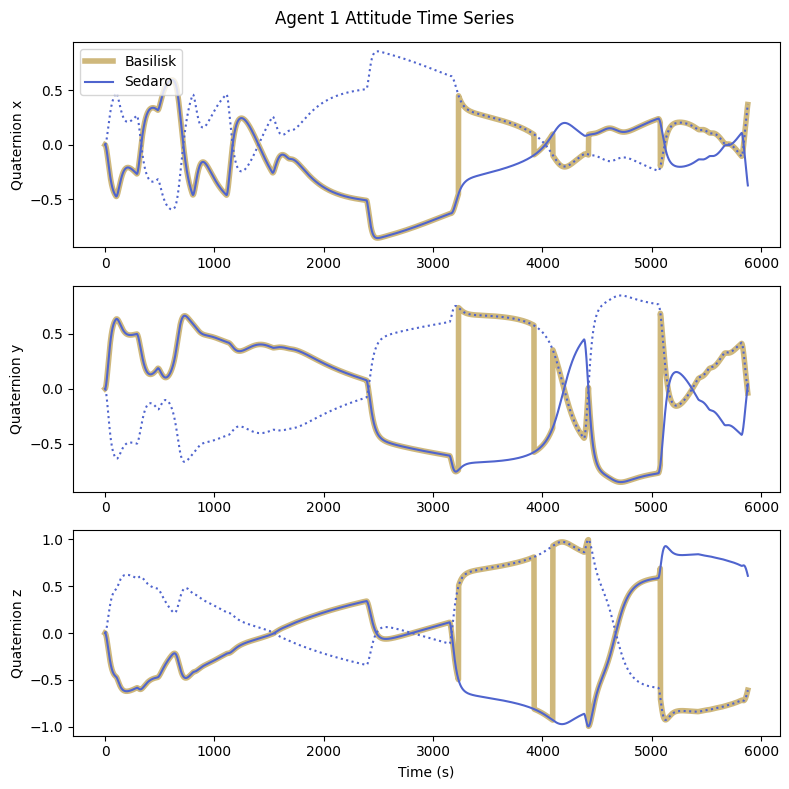

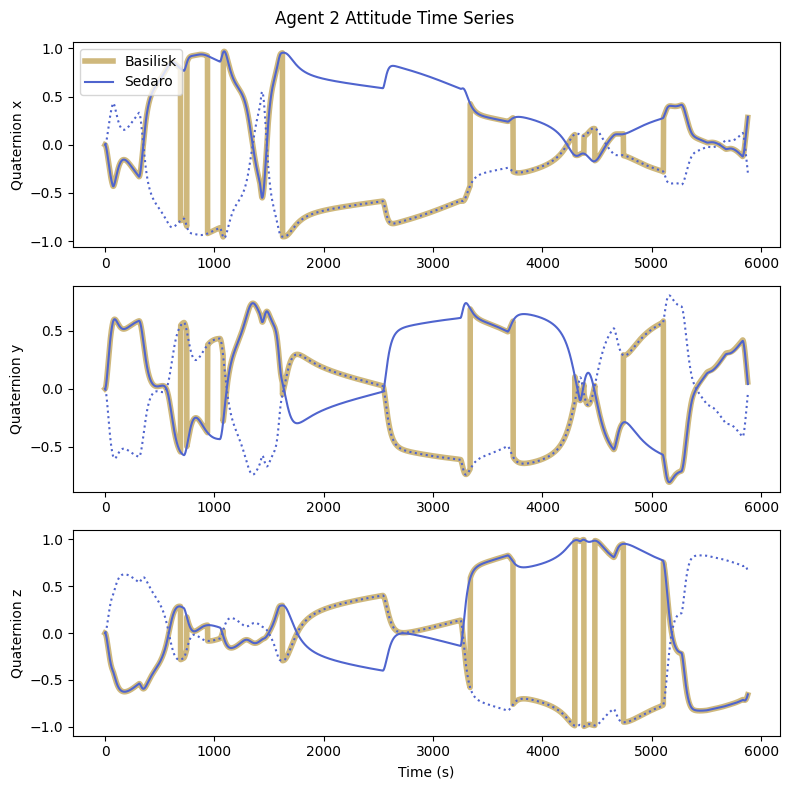

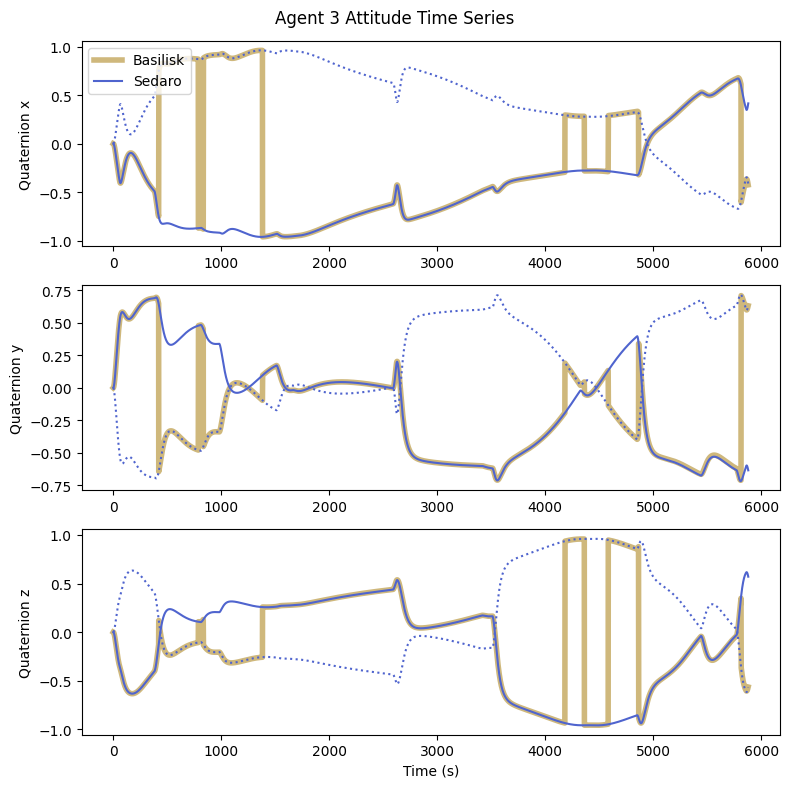

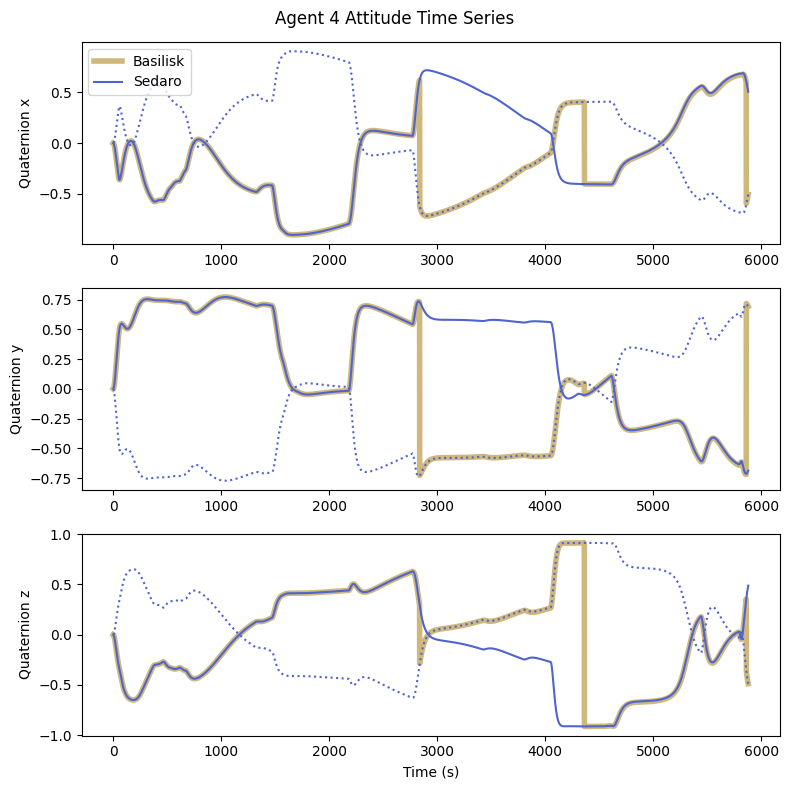

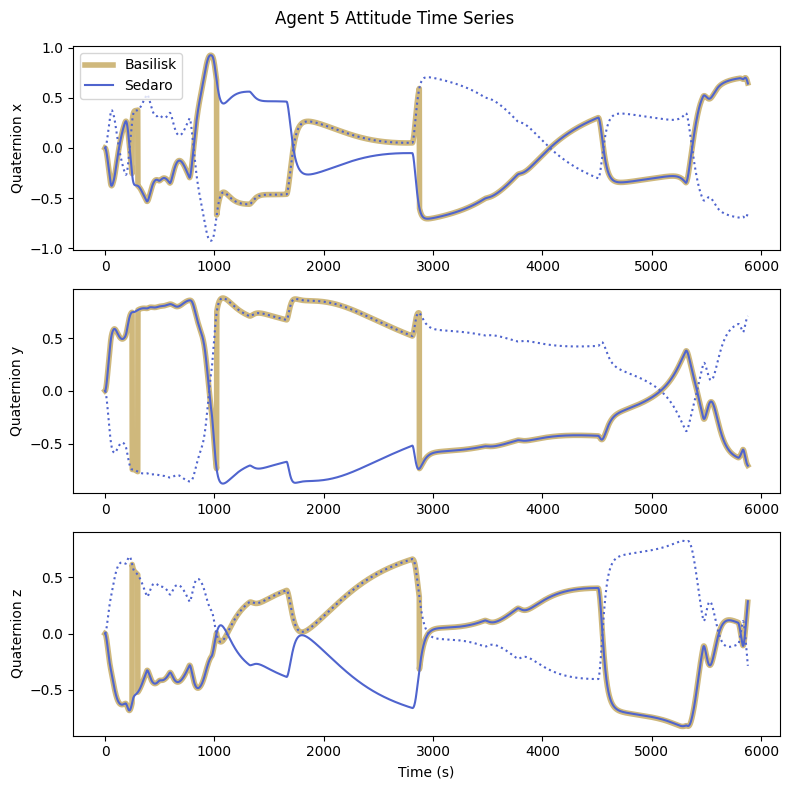

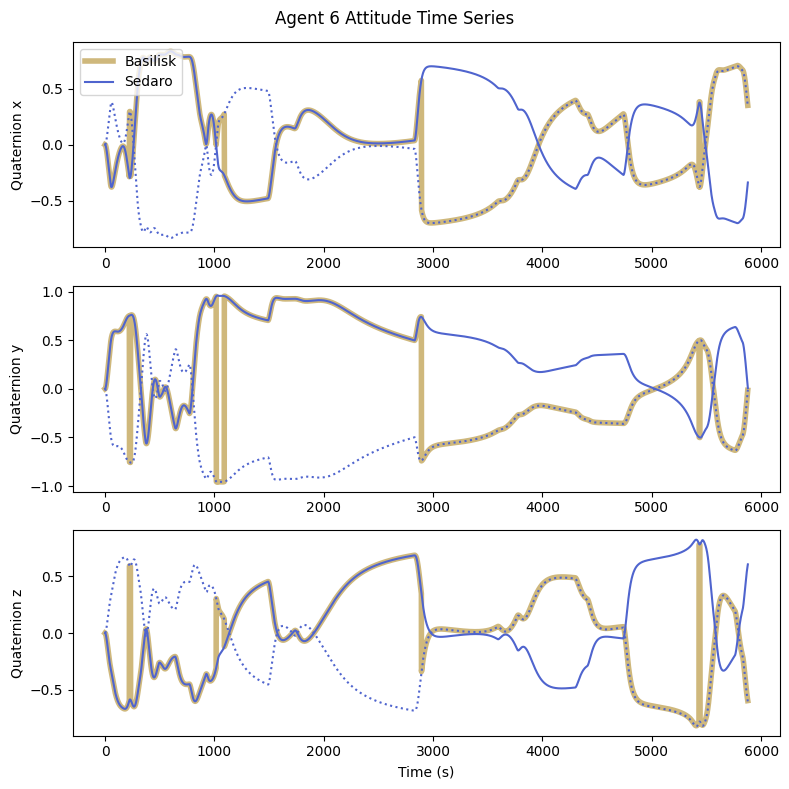

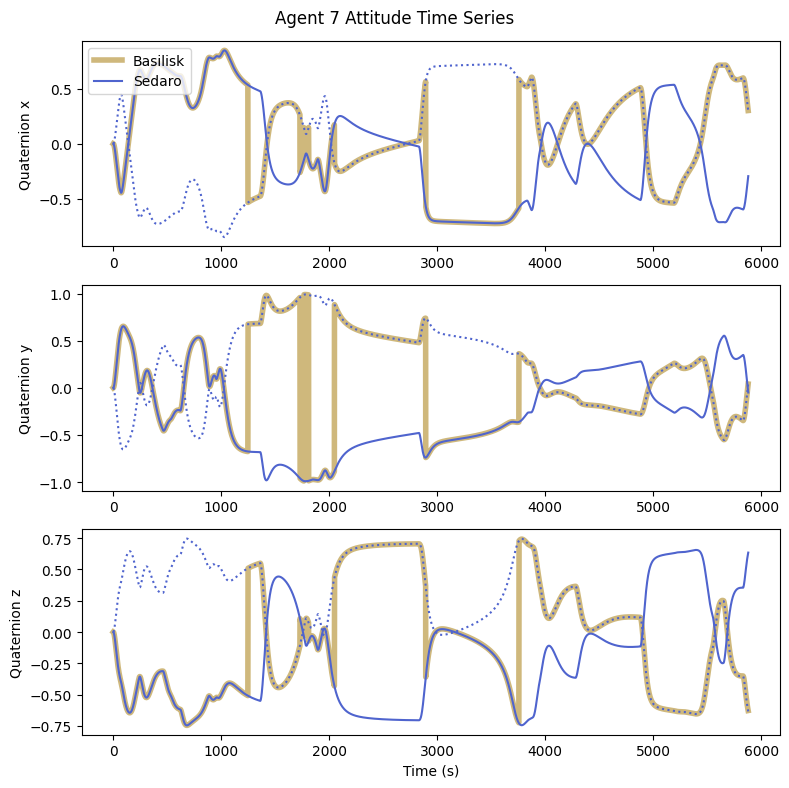

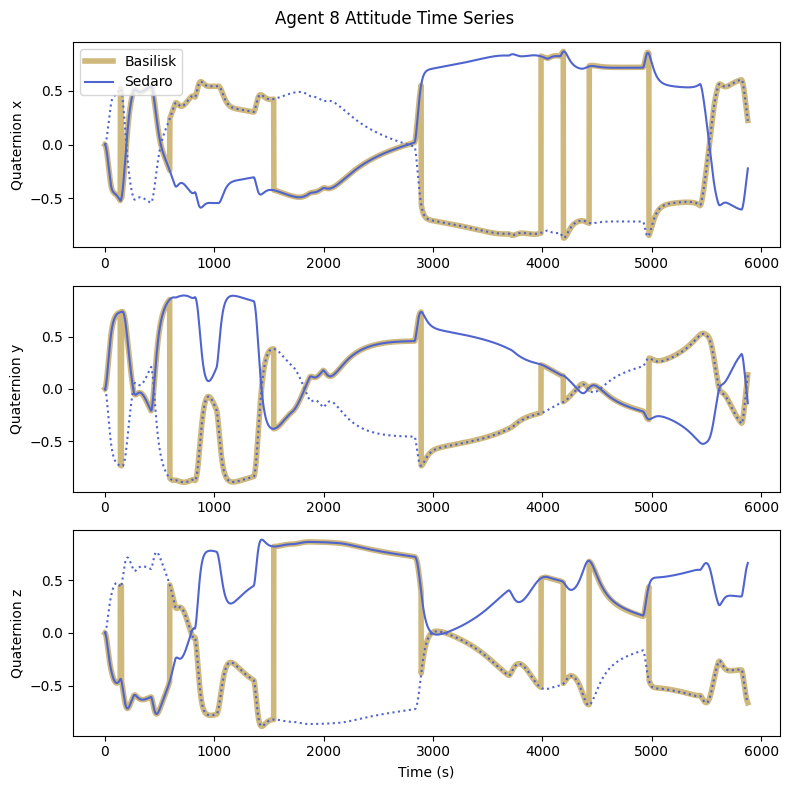

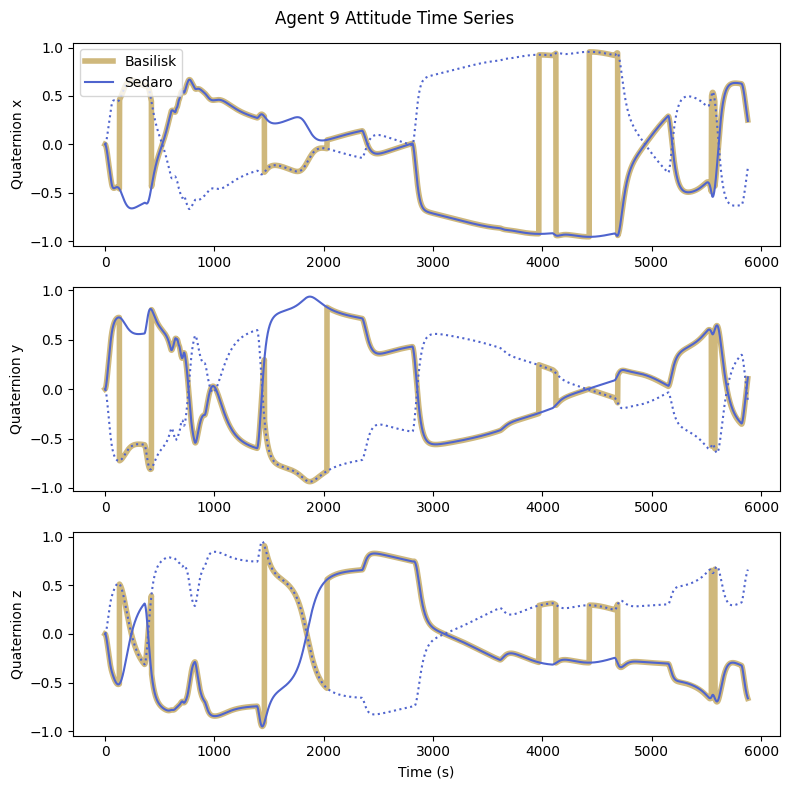

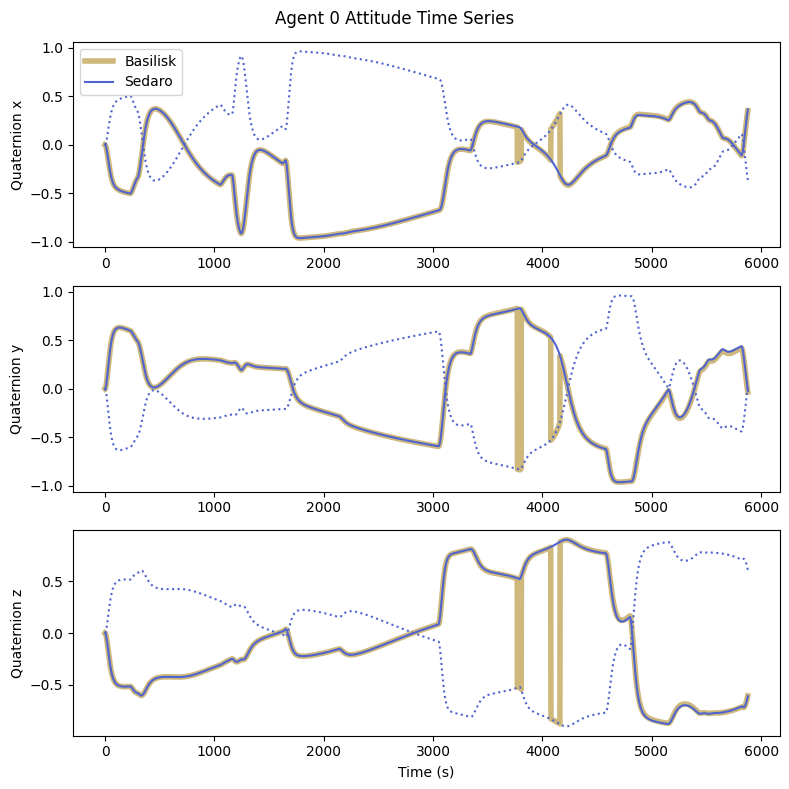

In [9]:
if not os.path.exists('plots/attitude'):
    os.makedirs('plots/attitude')
for agent_name in sedaro_attitude_results.keys():
    # Neatly grab data
    basilisk_attitude = np.array(basilisk_agent_attitude[agent_name])
    sedaro_attitude = sedaro_attitude_results[agent_name]
    ts = sedaro_ts[agent_name]
    basilisk_ts = basilisk_agent_time_arr[agent_name]

    # Plot the x, y, z components of the attitude quaternion
    fig, ax = plt.subplots(3, 1)
    # Plot x result
    ax[0].plot(basilisk_ts, basilisk_attitude[:,0], label='Basilisk', color=basilisk_gold,linewidth=4)
    ax[0].plot(ts, sedaro_attitude[:,0], color= sedaro_savoy, label='Sedaro')
    ax[0].plot(ts, -sedaro_attitude[:, 0], ':', color= sedaro_savoy)
    ax[0].legend(loc='upper left')
    ax[0].set_ylabel('Quaternion x')
    # Plot y result, no legend
    ax[1].plot(basilisk_ts, basilisk_attitude[:,1], color=basilisk_gold, linewidth=4)
    ax[1].plot(ts, sedaro_attitude[:,1], color= sedaro_savoy)
    ax[1].plot(ts, -sedaro_attitude[:, 1], ':', color= sedaro_savoy)
    ax[1].set_ylabel('Quaternion y')
    # Plot z result, no legend
    ax[2].plot(basilisk_ts,  basilisk_attitude[:,2], color=basilisk_gold,linewidth=4)
    ax[2].plot(ts, sedaro_attitude[:,2], color= sedaro_savoy)
    ax[2].plot(ts, -sedaro_attitude[:, 2], ':', color= sedaro_savoy)
    ax[2].set_ylabel('Quaternion z')
    ax[2].set_xlabel('Time (s)')
    fig.set_tight_layout(True)
    fig.suptitle(f'{agent_name} Attitude Time Series')
    fig.set_size_inches(8, 8)
    fig.savefig(f'plots/attitude/{agent_name}_attitude.png')

### Attitude Error
Using the Basilisk results as the "truth" plot the attitude error time series for each agent.

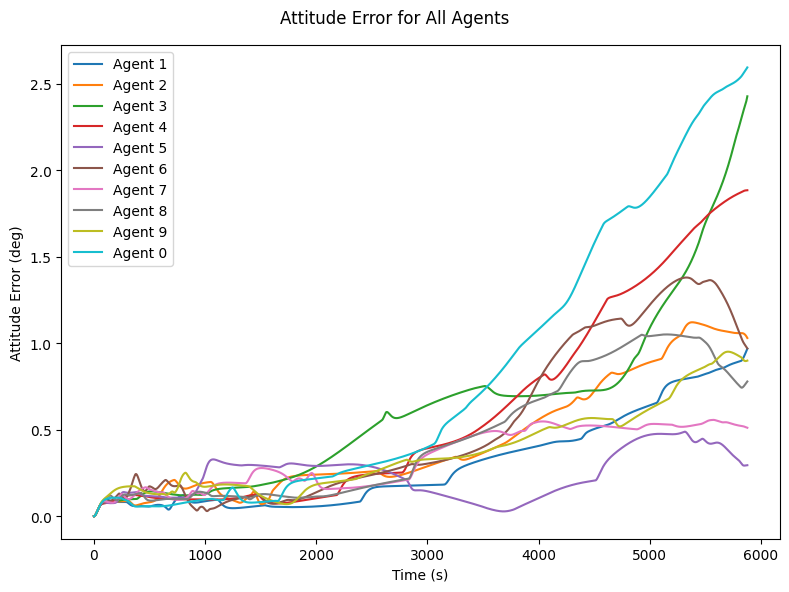

In [10]:
fig, ax = plt.subplots()    
for agent_name in sedaro_attitude_results.keys():
    # Neatly grab data
    basilisk_time_arr = np.array(basilisk_agent_time_arr[agent_name])
    ts = np.array(sedaro_ts[agent_name])
    basilisk_attitude = np.array(basilisk_agent_attitude[agent_name])
    sedaro_attitude = sedaro_attitude_results[agent_name]

    # Plot
    diff_angles = [np.degrees(angleBetweenClosestQuaternions(sedaro_q, t_1, basilisk_attitude, basilisk_time_arr)) 
                   for sedaro_q, t_1 in zip(sedaro_attitude, ts)]
    ax.plot(ts[:-1], diff_angles[:-1], label = agent_name)

# Label axes, etc.
ax.legend()
ax.set_ylabel('Attitude Error (deg)')
ax.set_xlabel('Time (s)')
fig.suptitle(f'Attitude Error for All Agents')
fig.set_tight_layout(True)
fig.set_size_inches(8, 6)
fig.savefig(f'plots/attitude/attitude_error.png')

### Reaction Wheel Speeds

We also want to check that the reaction wheel speeds respond as expected to the applied control torques.

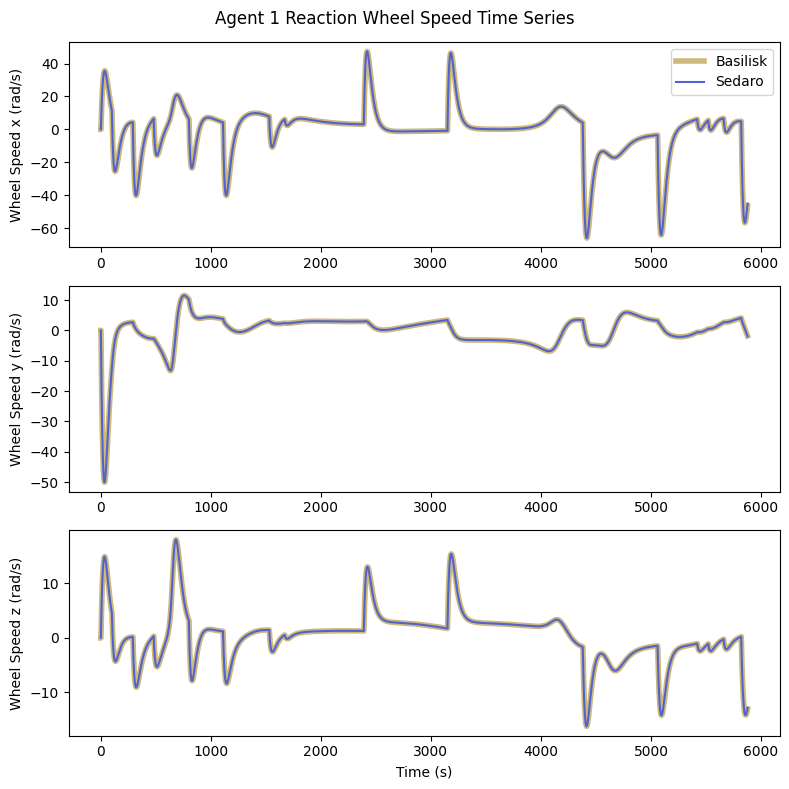

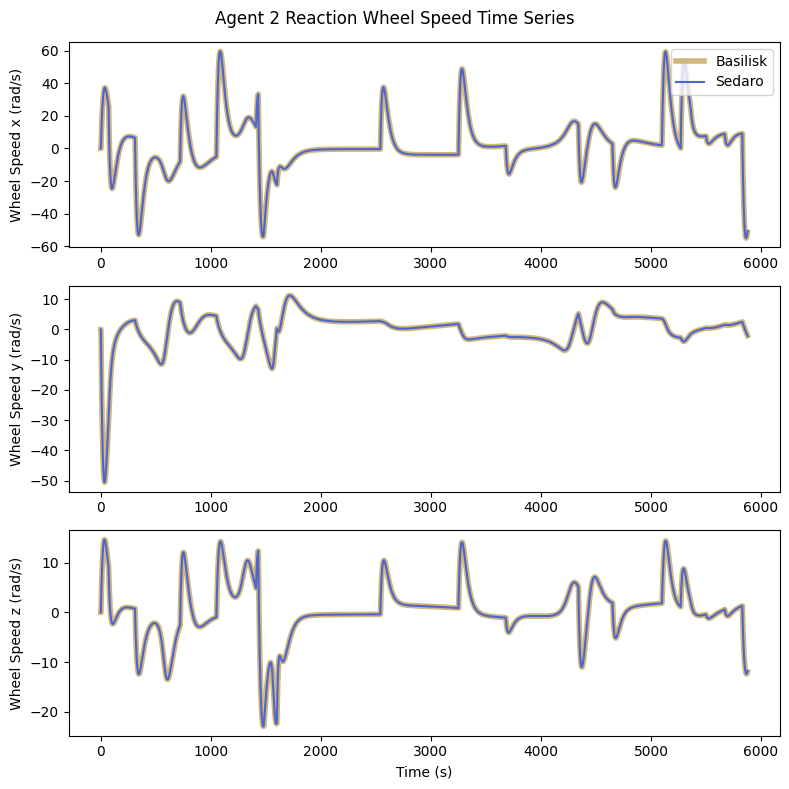

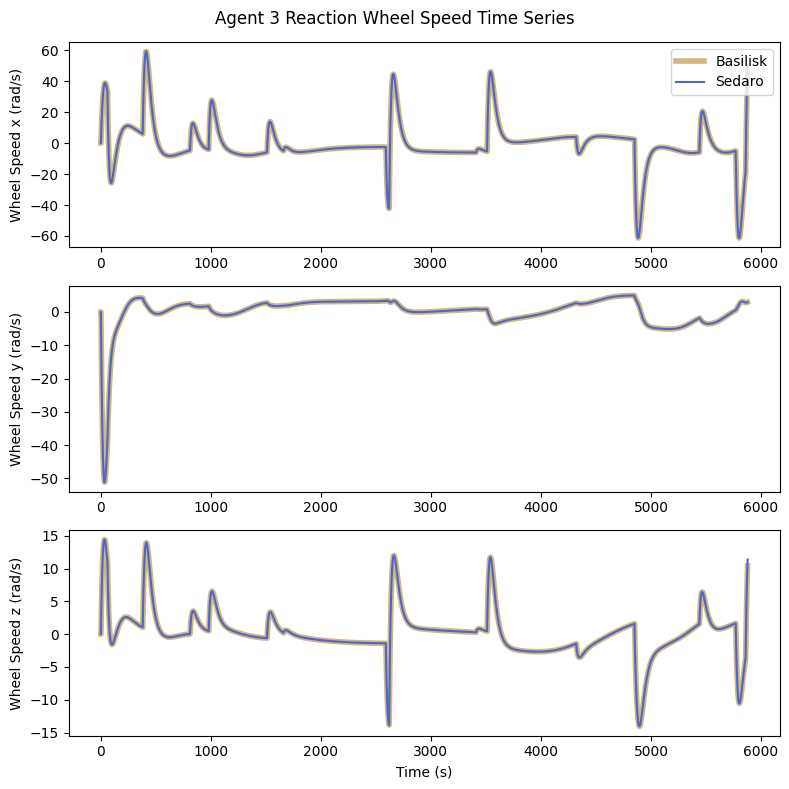

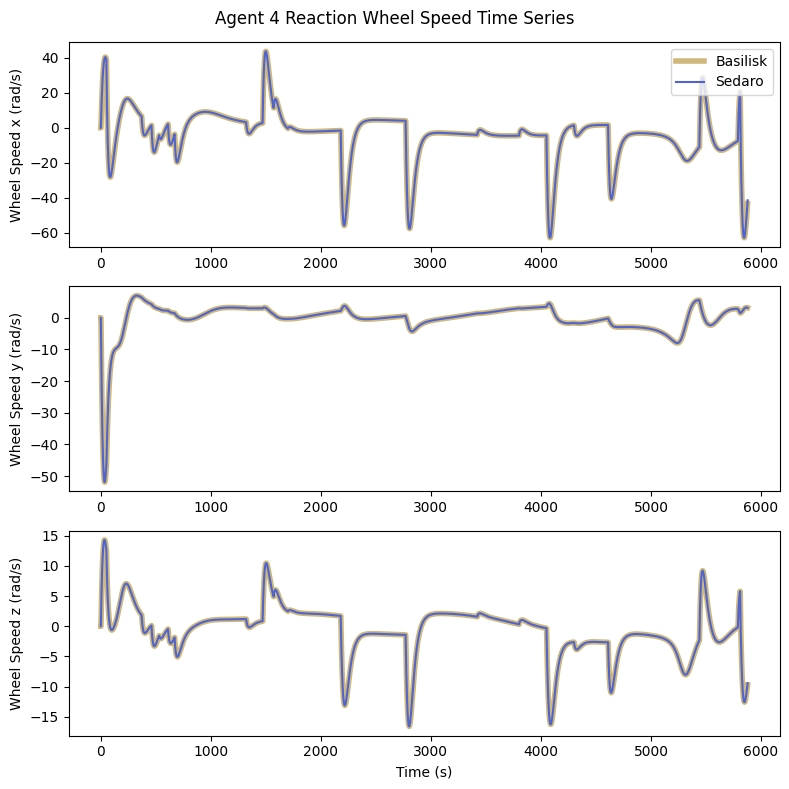

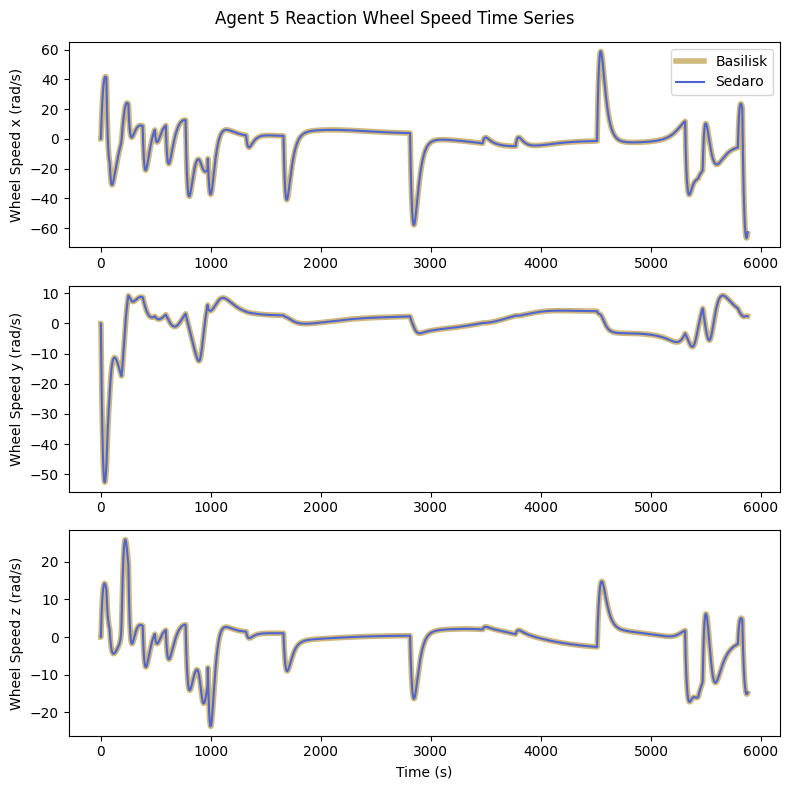

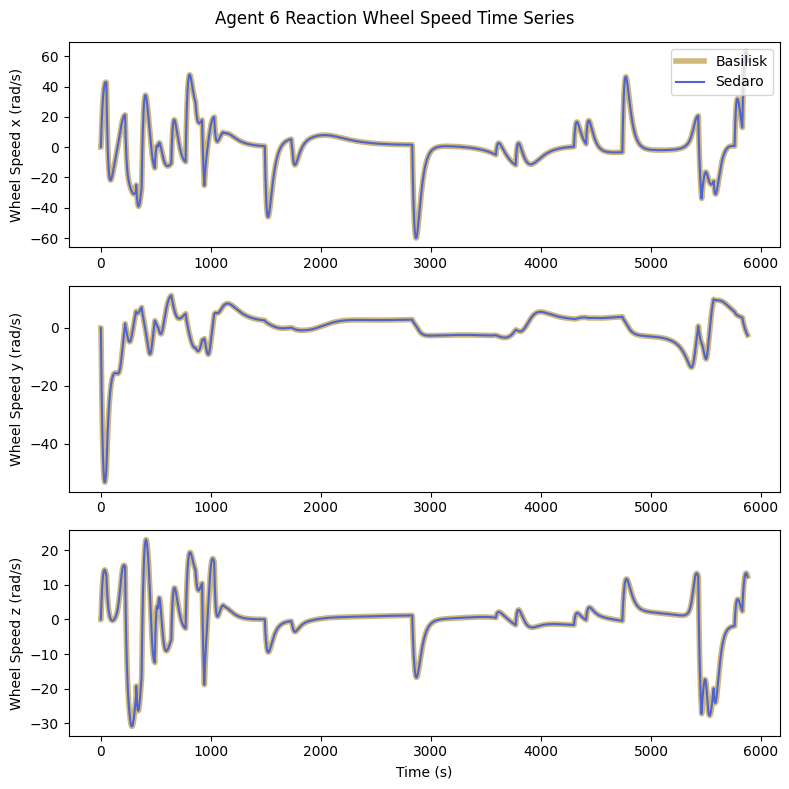

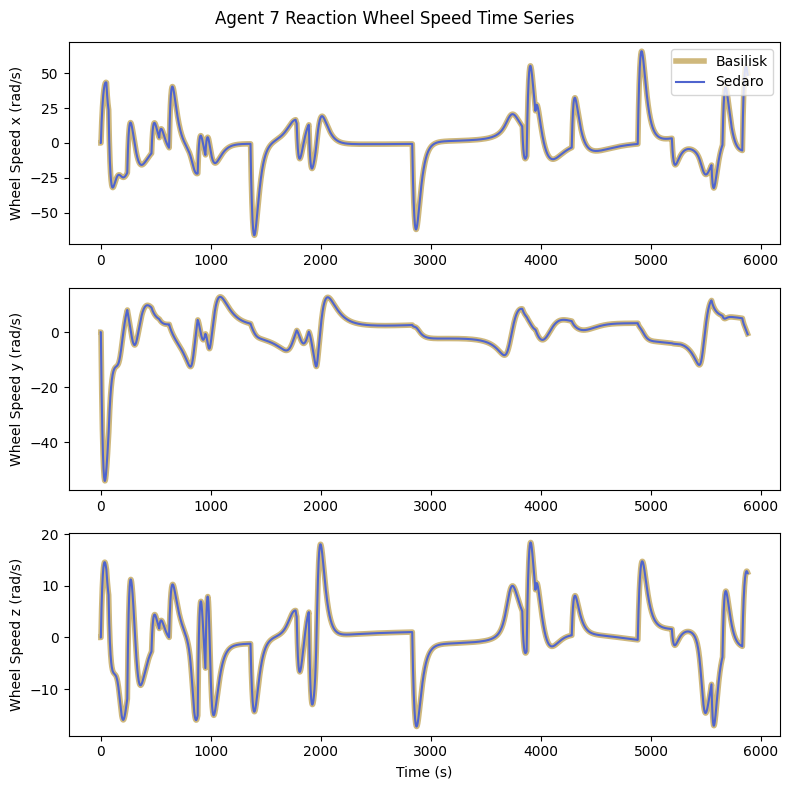

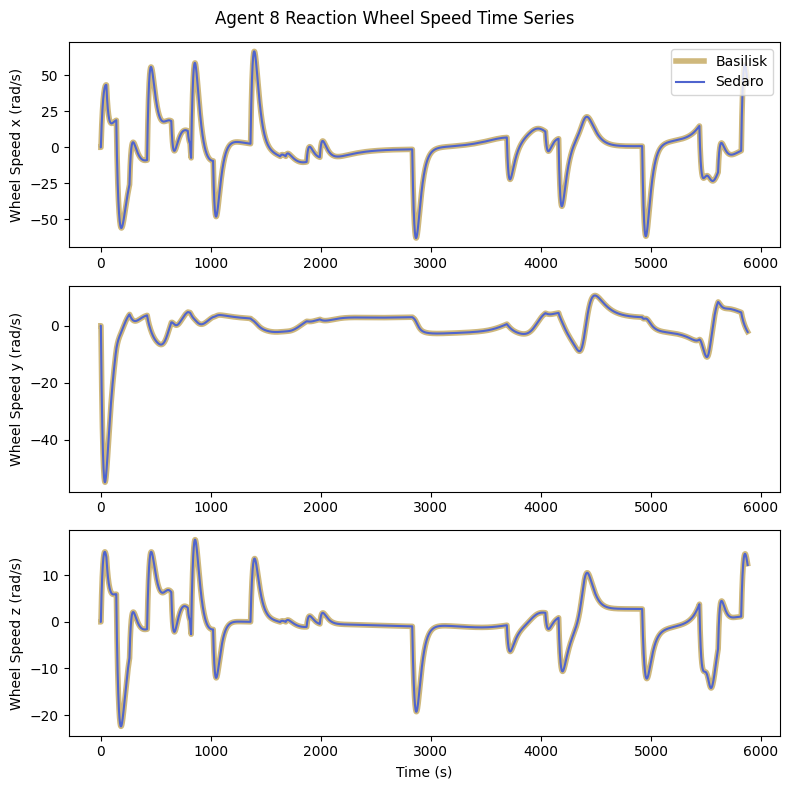

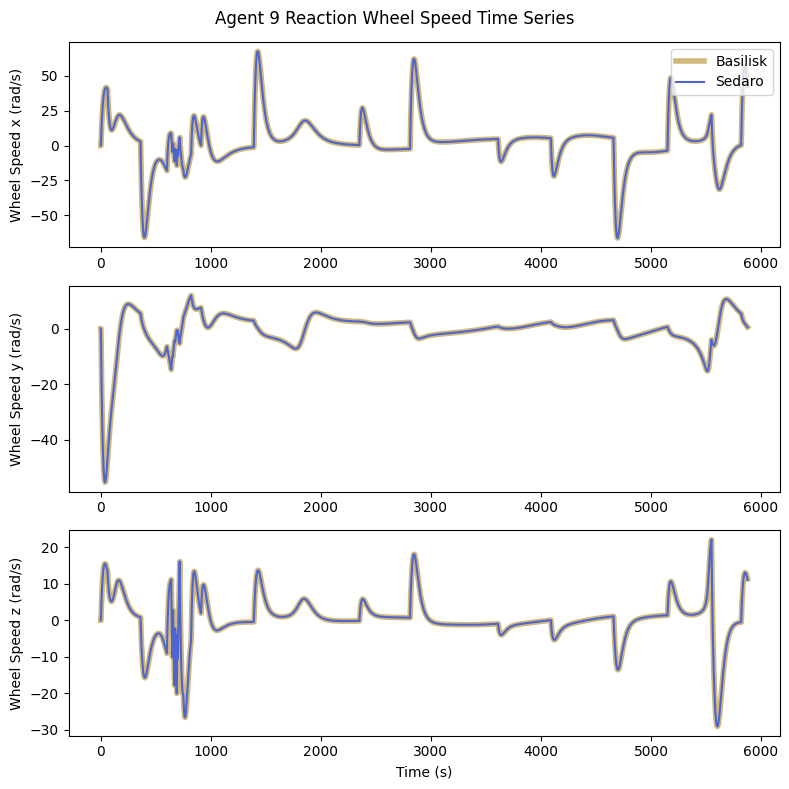

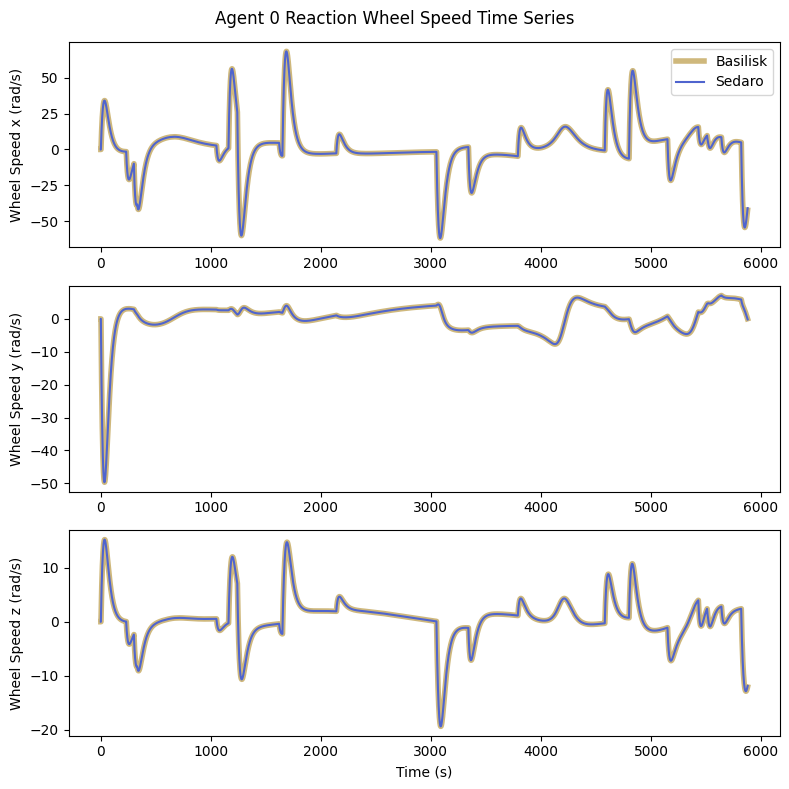

In [11]:
if not os.path.exists('plots/wheels'):
    os.makedirs('plots/wheels')
for agent_name in sedaro_attitude_results.keys():
    # Neatly grab data
    ts = sedaro_ts[agent_name]
    basilisk_ts = basilisk_agent_time_arr[agent_name]
    sedaro_xs = sedaro_omega_x[agent_name]
    sedaro_ys = sedaro_omega_y[agent_name]
    sedaro_zs = sedaro_omega_z[agent_name]
    basilisk_xs = basilisk_omega_x[agent_name]
    basilisk_ys = basilisk_omega_y[agent_name]
    basilisk_zs = basilisk_omega_z[agent_name]

    # Set up axes and plot
    fig,ax = plt.subplots(3, 1)
    # x
    ax[0].plot(basilisk_ts, basilisk_xs, label='Basilisk', color=basilisk_gold,linewidth=4)
    ax[0].plot(ts, sedaro_xs, label='Sedaro', color=sedaro_savoy)
    ax[0].set_ylabel('Wheel Speed x (rad/s)')
    ax[0].legend(loc='upper right')
    # y
    ax[1].plot(basilisk_ts, basilisk_ys, color=basilisk_gold,linewidth=4)
    ax[1].plot(ts, sedaro_ys, color=sedaro_savoy)
    ax[1].set_ylabel('Wheel Speed y (rad/s)')
    # z
    ax[2].plot(basilisk_ts, basilisk_zs, color=basilisk_gold,linewidth=4)
    ax[2].plot(ts, sedaro_zs, color=sedaro_savoy)
    ax[2].set_ylabel('Wheel Speed z (rad/s)')
    ax[2].set_xlabel('Time (s)')
    # Make axes look nice
    fig.set_tight_layout(True)
    fig.suptitle(f'{agent_name} Reaction Wheel Speed Time Series')
    fig.set_size_inches(8, 8)
    fig.savefig(f'plots/wheels/{agent_name}_wheels.png')